In [ ]:
#weight decay doesn't have a meaningful impact on validation accuracy

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import ast
from IPython.display import display
import numpy as np
import seaborn as sns

override_files = (list(Path('.').glob('**/overrides.yaml')))
df = pd.DataFrame()
for override_file in override_files:    
       
    factors = yaml.safe_load(override_file.read_text())
    factors = dict([elm.split('=') for elm in factors if elm[0] != '+'])
    
    factors = pd.DataFrame(factors,index=range(0,int(factors['epochs']))) #Factors df with a duplicate row per epoch
    factors['epoch'] = list(range(1,int(factors.epochs[0]) + 1 )) #Adding epoch number to each row
    
    log_file =  override_file.parent.parent /'TrainModel.log'
    with open(log_file) as f:
        metrics = [log.split("- ")[-1].strip().split(': ') for log in f.readlines()]
        metrics = pd.DataFrame({k:ast.literal_eval(v) for k,v in metrics}) #Metric df containing the log metrics
    
    #concat factor and metrics dfs to the final df
    df = pd.concat([df, pd.concat([factors, metrics],axis=1)])
    

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3960 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   optimizer.weight_decay  3960 non-null   object 
 1   epochs                  3960 non-null   object 
 2   epoch                   3960 non-null   int64  
 3   Train Accuracy          3960 non-null   float64
 4   Train Loss              3960 non-null   float64
 5   Validation Accuracy     3960 non-null   float64
 6   Validation Loss         3960 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 247.5+ KB


In [12]:
df = df.reset_index(drop=True)
df = df.rename(columns={'optimizer.weight_decay':'weight_decay'})
df.loc[df[df.weight_decay =='null'].index,: 'weight_decay'] =0.0
df.weight_decay = df.weight_decay.astype('float64')
df.epoch = df.epoch.astype('uint8')

In [13]:
desc = df[df.epoch > 6].groupby(['weight_decay']).describe()
val_acc = desc['Validation Accuracy'].reset_index().sort_values('50%', ascending=False)
train_acc = desc['Train Accuracy'].reset_index().sort_values('50%', ascending=False)

In [14]:
val_acc[val_acc['50%'] > 0.75]

,weight_decay,count,mean,std,min,25%,50%,75%,max
5,0.10000,546.0,0.768510,0.047083,0.539436,0.743940,0.777135,0.801646,0.856006
3,0.00100,546.0,0.770041,0.043808,0.608538,0.746744,0.775868,0.802008,0.848770
2,0.00010,546.0,0.759668,0.059974,0.498553,0.740684,0.773698,0.796943,0.862156
4,0.01000,546.0,0.767992,0.043291,0.553184,0.744664,0.772250,0.796672,0.881331
0,0.00000,546.0,0.763547,0.051645,0.574530,0.736523,0.769899,0.800199,0.853111
1,0.00001,546.0,0.760991,0.053397,0.526411,0.736614,0.769175,0.797576,0.890738


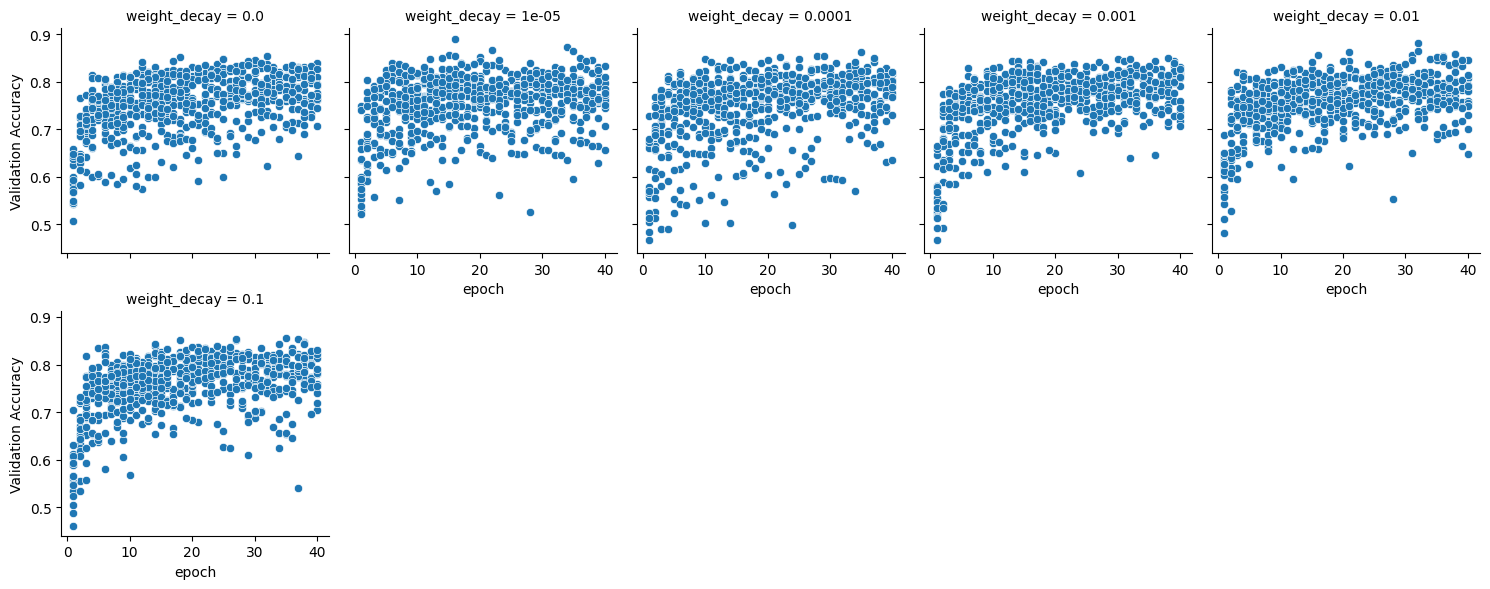

In [15]:
g = sns.FacetGrid(df, col = 'weight_decay', col_wrap=5)
g.map_dataframe(sns.scatterplot, x='epoch', y='Validation Accuracy')
plt.tight_layout()

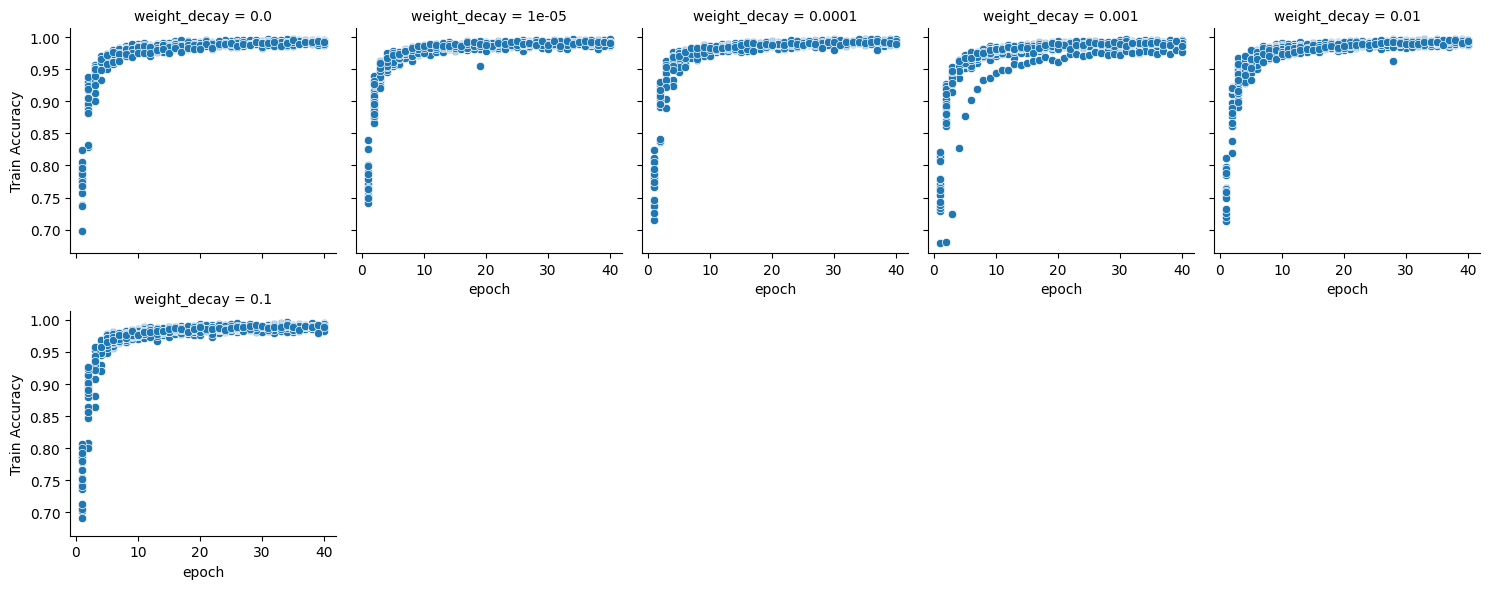

In [16]:
g = sns.FacetGrid(df, col = 'weight_decay', col_wrap=5)
g.map_dataframe(sns.scatterplot, x='epoch', y='Train Accuracy')
plt.tight_layout()

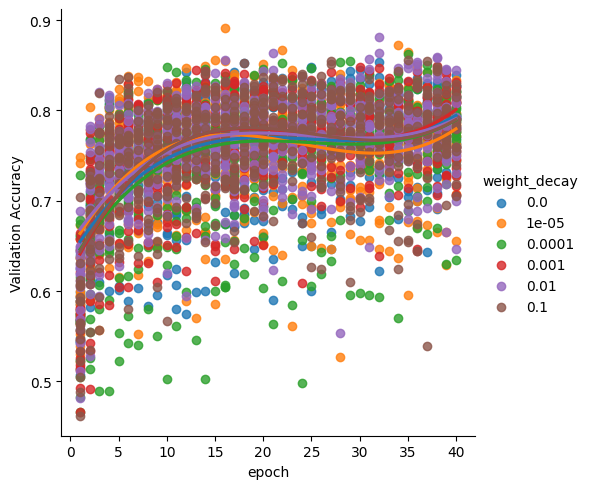

In [17]:
sns.lmplot(data=df,x='epoch',y='Validation Accuracy', hue='weight_decay', order=3)